In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [2]:
import os
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [3]:
os.chdir('..')
# os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [4]:
from fashion_recommendations.metrics.average_precision import mapk

In [5]:
pd.options.display.max_columns = None

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Load transactions

In [7]:
train_set_orig = pd.read_csv('data/splits/train_subset.tsv', sep='\t', dtype={'article_id': str}, usecols=['t_dat', 'customer_id', 'article_id'])
print(train_set_orig.shape)
train_set_orig.head()

(588758, 3)


,t_dat,customer_id,article_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023
2,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0650193004
3,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0527687006
4,2018-09-20,02bfe1a5248beb9cd28ad4ac630a6d75e78d9a3e14551a...,0668767002


In [8]:
test_set = pd.read_csv('data/splits/test_subset.tsv', sep='\t', dtype={'article_id': str}, usecols=['t_dat', 'customer_id', 'article_id'])
print(test_set.shape)
test_set.head()

(32995, 3)


,t_dat,customer_id,article_id
0,2020-09-15,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007
1,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010
2,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010
3,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0610776105
4,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0929745001


Only include articles bought after 2020-01:

In [9]:
train_set_orig['t_dat'] = pd.to_datetime(train_set_orig['t_dat'])

In [10]:
article_id_to_keep = train_set_orig[train_set_orig['t_dat'] > '2020-08-01']['article_id'].unique()

In [11]:
print(train_set_orig.shape)
train_set_orig = train_set_orig.copy()[train_set_orig['article_id'].isin(article_id_to_keep)]
print(train_set_orig.shape)

(588758, 3)
(202947, 3)


### Load customer features

In [12]:
customers = pd.read_csv('data/customers.csv')
print(customers.shape)
customers.head()

(1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [13]:
customers.isnull().sum() / customers.shape[0]

customer_id               0.000000
FN                        0.652378
Active                    0.661508
club_member_status        0.004418
fashion_news_frequency    0.011669
age                       0.011561
postal_code               0.000000
dtype: float64

In [14]:
customers[['FN', 'Active']] = customers[['FN', 'Active']].fillna(0)

In [15]:
customers['club_member_status'] = customers['club_member_status'].str.lower().str.replace('-', '_').str.replace(' ', '_').fillna('missing')

In [16]:
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].str.lower().str.replace('-', '_').str.replace(' ', '_').fillna('missing')

In [17]:
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace('none', 'missing')

In [18]:
customers.isnull().sum()

customer_id                   0
FN                            0
Active                        0
club_member_status            0
fashion_news_frequency        0
age                       15861
postal_code                   0
dtype: int64

In [19]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,active,missing,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,active,missing,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,active,missing,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,active,missing,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,active,regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [20]:
for col in customers.columns:
    print(col)
    print(customers[col].nunique())

customer_id
1371980
FN
2
Active
2
club_member_status
4
fashion_news_frequency
3
age
84
postal_code
352899


In [21]:
customers.drop('postal_code', axis=1, inplace=True)

In [22]:
customers = pd.get_dummies(customers, columns=['FN', 'Active'], drop_first=True)

In [23]:
customers = pd.get_dummies(customers, columns=['club_member_status', 'fashion_news_frequency'])

In [24]:
customers.head()

,customer_id,age,FN_1.0,Active_1.0,club_member_status_active,club_member_status_left_club,club_member_status_missing,club_member_status_pre_create,fashion_news_frequency_missing,fashion_news_frequency_monthly,fashion_news_frequency_regularly
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49.0,0,0,1,0,0,0,1,0,0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,25.0,0,0,1,0,0,0,1,0,0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24.0,0,0,1,0,0,0,1,0,0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,54.0,0,0,1,0,0,0,1,0,0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,52.0,1,1,1,0,0,0,0,0,1


### Load article features

In [25]:
articles_df = pd.read_csv(
    'data/articles.csv', 
    dtype={'article_id': str}, 
)
print(articles_df.shape)
articles_df.head()

(105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [26]:
for col in articles_df.columns:    
    if articles_df[col].nunique() <= 10:
        print(col)

perceived_colour_value_id
perceived_colour_value_name
index_code
index_name
index_group_no
index_group_name


In [27]:
cols_to_keep = [
    'article_id',
    'perceived_colour_value_name',
    'index_name',
    'index_group_name'
]

In [28]:
articles_df = articles_df.copy()[cols_to_keep]
articles_df = pd.get_dummies(articles_df, columns=['perceived_colour_value_name', 'index_name', 'index_group_name'])

print(articles_df.shape)
articles_df.head()

(105542, 24)


,article_id,perceived_colour_value_name_Bright,perceived_colour_value_name_Dark,perceived_colour_value_name_Dusty Light,perceived_colour_value_name_Light,perceived_colour_value_name_Medium,perceived_colour_value_name_Medium Dusty,perceived_colour_value_name_Undefined,perceived_colour_value_name_Unknown,index_name_Baby Sizes 50-98,"index_name_Children Accessories, Swimwear",index_name_Children Sizes 134-170,index_name_Children Sizes 92-140,index_name_Divided,index_name_Ladies Accessories,index_name_Ladieswear,index_name_Lingeries/Tights,index_name_Menswear,index_name_Sport,index_group_name_Baby/Children,index_group_name_Divided,index_group_name_Ladieswear,index_group_name_Menswear,index_group_name_Sport
0,0108775015,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,0108775044,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,0108775051,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0110065001,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,0110065002,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


### Train-dev split

In [29]:
end = train_set_orig['t_dat'].max()
endm1 = end - datetime.timedelta(days=7)

endm1, end

(Timestamp('2020-09-07 00:00:00'), Timestamp('2020-09-14 00:00:00'))

In [30]:
train_set = train_set_orig.copy()[train_set_orig['t_dat'] < endm1]

dev_set = train_set_orig.copy()[train_set_orig['t_dat'] >= endm1]

train_set.drop(columns=['t_dat'], inplace=True)
dev_set.drop(columns=['t_dat'], inplace=True)

train_set.shape, dev_set.shape

((194584, 2), (8363, 2))

### Generate negative samples

In [31]:
train_set.head()

,customer_id,article_id
17,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0575347003
43,09bca14258b7e9b9ee968adffe54d45c1e370e8ed79a22...,0579541001
55,183c939bc508ee9c530be249a4e940aace700cdc774e2c...,0615141002
72,1b9496dbe47dd45ffff1630aa2b532d1a5c924c6104d66...,0562245046
77,1b9496dbe47dd45ffff1630aa2b532d1a5c924c6104d66...,0562245001


In [32]:
top_1000 = train_set['article_id'].value_counts().head(1000).index.tolist()
top_1000[:5]

['0706016001', '0706016002', '0372860001', '0610776002', '0759871002']

In [33]:
train_set_by_customer = train_set.groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
print(train_set_by_customer.shape)
train_set_by_customer.head()

(8778, 2)


,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0723529001, 0351484002, 0351484002, 0851400006]"
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0714029002, 0591334019, 0685813001, 075147100..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0570002001, 0770816001, 0501620042, 082217100..."
3,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0201219001, 0322017003, 0156231001, 075475100..."
4,004d932f7a27ac3167c77db81d9cfd89392729e7f7e0d4...,"[0679854005, 0679854005, 0679854005, 057371601..."


In [34]:
train_set_by_customer['negative_samples'] = train_set_by_customer.apply(lambda x: list(set(top_1000) - set(x['article_id'])), axis=1)

In [35]:
train_set_by_customer['num_negative_samples'] = train_set_by_customer['negative_samples'].apply(len)

<AxesSubplot:>

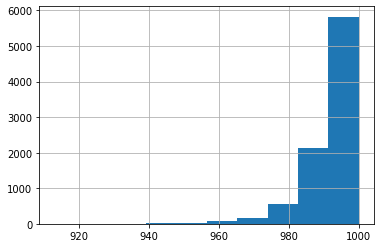

In [36]:
train_set_by_customer['num_negative_samples'].hist()

In [37]:
(train_set_by_customer['num_negative_samples'] == 1000).mean()

0.06687172476646161

Drop customers with 1000 negative examples, which means they had no positive examples in this set

In [38]:
train_set_by_customer = train_set_by_customer.copy()[train_set_by_customer['num_negative_samples'] != 1000]

In [39]:
train_set_by_customer.head()

,customer_id,article_id,negative_samples,num_negative_samples
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0723529001, 0351484002, 0351484002, 0851400006]","[0589599033, 0857812003, 0815434001, 074309800...",998
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0714029002, 0591334019, 0685813001, 075147100...","[0589599033, 0857812003, 0815434001, 074309800...",989
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0570002001, 0770816001, 0501620042, 082217100...","[0589599033, 0857812003, 0815434001, 074309800...",999
3,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0201219001, 0322017003, 0156231001, 075475100...","[0589599033, 0857812003, 0815434001, 074309800...",990
4,004d932f7a27ac3167c77db81d9cfd89392729e7f7e0d4...,"[0679854005, 0679854005, 0679854005, 057371601...","[0589599033, 0857812003, 0815434001, 074309800...",988


In [40]:
negative_samples_df = train_set_by_customer[['customer_id', 'negative_samples']].explode('negative_samples')
negative_samples_df['purchased'] = 0
negative_samples_df.rename(columns={'negative_samples': 'article_id'}, inplace=True)
print(negative_samples_df.shape)
negative_samples_df.head()

(8123061, 3)


,customer_id,article_id,purchased
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0589599033,0
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0857812003,0
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0815434001,0
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0743098002,0
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0816423003,0


In [41]:
positive_samples = train_set.copy()
positive_samples['purchased'] = 1
print(positive_samples.shape)
positive_samples.head()

(194584, 3)


,customer_id,article_id,purchased
17,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0575347003,1
43,09bca14258b7e9b9ee968adffe54d45c1e370e8ed79a22...,0579541001,1
55,183c939bc508ee9c530be249a4e940aace700cdc774e2c...,0615141002,1
72,1b9496dbe47dd45ffff1630aa2b532d1a5c924c6104d66...,0562245046,1
77,1b9496dbe47dd45ffff1630aa2b532d1a5c924c6104d66...,0562245001,1


In [42]:
train_set = pd.concat([
    positive_samples,
    negative_samples_df
])

train_set = train_set.sample(frac=1, random_state=3)  # shuffle
print(train_set.shape)
train_set.head()

(8317645, 3)


,customer_id,article_id,purchased
5929,aac5c27e8ff10c78094f33226306eb4452e200c5526ebc...,0399087021,0
291955,6ad2c5538d44def5d641d52bf37920d403732a3a99b7f8...,0706016003,1
2754,4e69ef94d9f827c40d8d204fa87964458ea3283f098491...,0574109012,0
1101,1fee16017a65fa3e2ae5724ae14483906371851deb277b...,0915529003,0
4121,75f0b5668d08bbdebb8f422bfae7e395bc1775d0433aae...,0684209027,0


In [43]:
train_set['purchased'].mean()

0.023394121773651074

In [46]:
# Check at least 1 positive label per customer
train_set.groupby('customer_id')['purchased'].sum().min() >= 1

True

Dev set prep

In [47]:
dev_set.head()

,customer_id,article_id
580395,00639e775b90554156986100685c4d408723c77e411e37...,0891591007
580396,00639e775b90554156986100685c4d408723c77e411e37...,0891591001
580397,016f3b7c2b7652870b4b2dbdcb1805a7c8c262036f5511...,0909924004
580398,016f3b7c2b7652870b4b2dbdcb1805a7c8c262036f5511...,0921266005
580399,016f3b7c2b7652870b4b2dbdcb1805a7c8c262036f5511...,0857163001


In [50]:
# For purposes of dev set only include transactions in top-1000
dev_set['article_id'].isin(top_1000).mean()

0.14564151620231974

In [52]:
positive_samples_dev = dev_set.copy()[dev_set['article_id'].isin(top_1000)]
positive_samples_dev['purchased'] = 1
print(positive_samples_dev.shape)
positive_samples_dev.head()

(1218, 3)


,customer_id,article_id,purchased
580405,0214f55e8127a249145342bf9481a6c938d1afedc0d61a...,0536139006,1
580422,04b52cadd5ae3ddd45ce4d7d851d0a4ac8a10b70e06397...,0557994003,1
580432,07cc5dd914ff5c829caa6ef179a807dc0b5ba23acb011f...,0896169002,1
580434,085d2f6d807ca15772cdbbedbf0cb486a461e086e7023e...,0759482001,1
580435,085d2f6d807ca15772cdbbedbf0cb486a461e086e7023e...,0759482001,1


In [53]:
positive_samples_dev_by_customer = positive_samples_dev.groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
print(positive_samples_dev_by_customer.shape)
positive_samples_dev_by_customer.head()

(711, 2)


,customer_id,article_id
0,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,[0448509014]
1,00c14b39b44326040fc0d049d9bcb580a433e86401f7b9...,[0452818001]
2,012b7cc3c5080e46dac622a12e99d23510a4d67a4037d1...,"[0933706001, 0933706001]"
3,012dddef2db56c08e4f993e32ea3a1ff91fedb4fa950d9...,[0655784001]
4,0180d0ef5499cd4dfd920c19821c5f1e3f6692662e7d78...,"[0554450036, 0856440001]"


In [54]:
positive_samples_dev_by_customer['negative_samples'] = positive_samples_dev_by_customer.apply(lambda x: list(set(top_1000) - set(x['article_id'])), axis=1)

In [56]:
negative_samples_df = positive_samples_dev_by_customer[['customer_id', 'negative_samples']].explode('negative_samples')
negative_samples_df['purchased'] = 0
negative_samples_df.rename(columns={'negative_samples': 'article_id'}, inplace=True)
print(negative_samples_df.shape)
negative_samples_df.head()

(709939, 3)


,customer_id,article_id,purchased
0,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,0589599033,0
0,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,0857812003,0
0,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,0815434001,0
0,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,0743098002,0
0,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,0816423003,0


In [57]:
dev_set = pd.concat([
    positive_samples_dev,
    negative_samples_df
])

dev_set = dev_set.sample(frac=1, random_state=3)  # shuffle
print(dev_set.shape)
dev_set.head()

(711157, 3)


,customer_id,article_id,purchased
488,aa47179e404b61a599214735b3d0ee37ad4f936c87731b...,0850241006,0
100,25e866c8fd9a6bd0f9ffa423946cb0249981bc048482ad...,0690936023,0
395,87d5f7c850f802c3b5eed35b3d320cbd1c0a065f8faec2...,0719957006,0
480,a67cfa9a713cf75008a1ab1a30f71aa0e1508bcc726d6c...,0762846008,0
371,817a4dfd1d0bfca122e17ce92cc7dfef6442940a403e69...,0791587009,0


In [58]:
dev_set['purchased'].mean()

0.0017127019772005339

### Merge features

In [59]:
train_set = (
    train_set
    .merge(customers, on='customer_id', how='left')
    .merge(articles_df, on='article_id', how='left')
)
print(train_set.shape)
train_set.head()

(8317645, 36)


,customer_id,article_id,purchased,age,FN_1.0,Active_1.0,club_member_status_active,club_member_status_left_club,club_member_status_missing,club_member_status_pre_create,fashion_news_frequency_missing,fashion_news_frequency_monthly,fashion_news_frequency_regularly,perceived_colour_value_name_Bright,perceived_colour_value_name_Dark,perceived_colour_value_name_Dusty Light,perceived_colour_value_name_Light,perceived_colour_value_name_Medium,perceived_colour_value_name_Medium Dusty,perceived_colour_value_name_Undefined,perceived_colour_value_name_Unknown,index_name_Baby Sizes 50-98,"index_name_Children Accessories, Swimwear",index_name_Children Sizes 134-170,index_name_Children Sizes 92-140,index_name_Divided,index_name_Ladies Accessories,index_name_Ladieswear,index_name_Lingeries/Tights,index_name_Menswear,index_name_Sport,index_group_name_Baby/Children,index_group_name_Divided,index_group_name_Ladieswear,index_group_name_Menswear,index_group_name_Sport
0,aac5c27e8ff10c78094f33226306eb4452e200c5526ebc...,0399087021,0,24.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,6ad2c5538d44def5d641d52bf37920d403732a3a99b7f8...,0706016003,1,29.0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,4e69ef94d9f827c40d8d204fa87964458ea3283f098491...,0574109012,0,26.0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,1fee16017a65fa3e2ae5724ae14483906371851deb277b...,0915529003,0,21.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,75f0b5668d08bbdebb8f422bfae7e395bc1775d0433aae...,0684209027,0,40.0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [60]:
dev_set = (
    dev_set
    .merge(customers, on='customer_id', how='left')
    .merge(articles_df, on='article_id', how='left')
)
print(dev_set.shape)
dev_set.head()

(711157, 36)


,customer_id,article_id,purchased,age,FN_1.0,Active_1.0,club_member_status_active,club_member_status_left_club,club_member_status_missing,club_member_status_pre_create,fashion_news_frequency_missing,fashion_news_frequency_monthly,fashion_news_frequency_regularly,perceived_colour_value_name_Bright,perceived_colour_value_name_Dark,perceived_colour_value_name_Dusty Light,perceived_colour_value_name_Light,perceived_colour_value_name_Medium,perceived_colour_value_name_Medium Dusty,perceived_colour_value_name_Undefined,perceived_colour_value_name_Unknown,index_name_Baby Sizes 50-98,"index_name_Children Accessories, Swimwear",index_name_Children Sizes 134-170,index_name_Children Sizes 92-140,index_name_Divided,index_name_Ladies Accessories,index_name_Ladieswear,index_name_Lingeries/Tights,index_name_Menswear,index_name_Sport,index_group_name_Baby/Children,index_group_name_Divided,index_group_name_Ladieswear,index_group_name_Menswear,index_group_name_Sport
0,aa47179e404b61a599214735b3d0ee37ad4f936c87731b...,0850241006,0,25.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,25e866c8fd9a6bd0f9ffa423946cb0249981bc048482ad...,0690936023,0,58.0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,87d5f7c850f802c3b5eed35b3d320cbd1c0a065f8faec2...,0719957006,0,31.0,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,a67cfa9a713cf75008a1ab1a30f71aa0e1508bcc726d6c...,0762846008,0,50.0,1,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,817a4dfd1d0bfca122e17ce92cc7dfef6442940a403e69...,0791587009,0,25.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


### Impute `NULL`s

In [61]:
train_set.isnull().sum()[train_set.isnull().sum() > 0]

age    28229
dtype: int64

In [62]:
dev_set.isnull().sum()[dev_set.isnull().sum() > 0]

age    4000
dtype: int64

In [63]:
from sklearn.impute import SimpleImputer

In [64]:
age_imputer = SimpleImputer()

In [65]:
age_imputer.fit(train_set['age'].values.reshape(-1, 1))

SimpleImputer()

In [66]:
train_set['age'] = age_imputer.transform(train_set['age'].values.reshape(-1, 1))

In [67]:
dev_set['age'] = age_imputer.transform(dev_set['age'].values.reshape(-1, 1))

### Train LGBMRanker

Based on https://stackoverflow.com/questions/64294962/how-to-implement-learning-to-rank-using-lightgbm

In [68]:
import re

In [69]:
train_set.columns = [re.sub(r'[^\w\s]','',s).replace(' ', '') for s in train_set.columns]
dev_set.columns = [re.sub(r'[^\w\s]','',s).replace(' ', '') for s in dev_set.columns]

In [70]:
train_set.sort_values('customer_id', inplace=True)
train_set.head()

,customer_id,article_id,purchased,age,FN_10,Active_10,club_member_status_active,club_member_status_left_club,club_member_status_missing,club_member_status_pre_create,fashion_news_frequency_missing,fashion_news_frequency_monthly,fashion_news_frequency_regularly,perceived_colour_value_name_Bright,perceived_colour_value_name_Dark,perceived_colour_value_name_DustyLight,perceived_colour_value_name_Light,perceived_colour_value_name_Medium,perceived_colour_value_name_MediumDusty,perceived_colour_value_name_Undefined,perceived_colour_value_name_Unknown,index_name_BabySizes5098,index_name_ChildrenAccessoriesSwimwear,index_name_ChildrenSizes134170,index_name_ChildrenSizes92140,index_name_Divided,index_name_LadiesAccessories,index_name_Ladieswear,index_name_LingeriesTights,index_name_Menswear,index_name_Sport,index_group_name_BabyChildren,index_group_name_Divided,index_group_name_Ladieswear,index_group_name_Menswear,index_group_name_Sport
3684530,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0506098007,0,24.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4579577,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0562245102,0,24.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1300398,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0829302001,0,24.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1198544,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0739144004,0,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
5092295,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0399136004,0,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [71]:
dev_set.sort_values('customer_id', inplace=True)
dev_set.head()

,customer_id,article_id,purchased,age,FN_10,Active_10,club_member_status_active,club_member_status_left_club,club_member_status_missing,club_member_status_pre_create,fashion_news_frequency_missing,fashion_news_frequency_monthly,fashion_news_frequency_regularly,perceived_colour_value_name_Bright,perceived_colour_value_name_Dark,perceived_colour_value_name_DustyLight,perceived_colour_value_name_Light,perceived_colour_value_name_Medium,perceived_colour_value_name_MediumDusty,perceived_colour_value_name_Undefined,perceived_colour_value_name_Unknown,index_name_BabySizes5098,index_name_ChildrenAccessoriesSwimwear,index_name_ChildrenSizes134170,index_name_ChildrenSizes92140,index_name_Divided,index_name_LadiesAccessories,index_name_Ladieswear,index_name_LingeriesTights,index_name_Menswear,index_name_Sport,index_group_name_BabyChildren,index_group_name_Divided,index_group_name_Ladieswear,index_group_name_Menswear,index_group_name_Sport
192612,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,0189626001,0,38.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
659707,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,0557599022,0,38.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
467168,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,0519583008,0,38.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
485863,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,0811783002,0,38.0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
610426,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,0759479001,0,38.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [72]:
qids_train = train_set.groupby("customer_id")["customer_id"].count().to_numpy()
X_train = train_set.drop(["customer_id", "article_id", "purchased"], axis=1)
y_train = train_set["purchased"]

qids_dev = dev_set.groupby("customer_id")["customer_id"].count().to_numpy()
X_dev = dev_set.drop(["customer_id", "article_id", "purchased"], axis=1)
y_dev = dev_set["purchased"]

In [73]:
import lightgbm

In [110]:
model = lightgbm.LGBMRanker(
    objective="lambdarank",
    metric=["map", "ndcg"],
    max_depth=2,
    n_estimators=20,
    random_state=3
)

In [111]:
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 20,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'lambdarank',
 'random_state': 3,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': ['map', 'ndcg']}

In [112]:
%%time
model.fit(
    X=X_train,
    y=y_train,
    group=qids_train,
    eval_set=[(X_dev, y_dev)],
    eval_group=[qids_dev],
    eval_at=12,
    verbose=10,
)

/Users/stevengeorge/opt/anaconda3/envs/fashion_rec/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's map@12: 0.00300717	valid_0's ndcg@12: 0.00424247
[20]	valid_0's map@12: 0.00584792	valid_0's ndcg@12: 0.0082172
CPU times: user 57 s, sys: 3.61 s, total: 1min
Wall time: 10.8 s


LGBMRanker(max_depth=2, metric=['map', 'ndcg'], n_estimators=20,
           objective='lambdarank', random_state=3)

In [113]:
predictions_dev = model.predict(X_dev)

In [114]:
dev_set['predictions'] = predictions_dev

In [115]:
predictions_list = (
    dev_set
    .sort_values(['customer_id', 'predictions'], ascending=False)
    .groupby('customer_id').head(12)
    .groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
)
predictions_list.head()

,customer_id,article_id
0,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,"[0743098001, 0918292011, 0818031003, 085025900..."
1,00c14b39b44326040fc0d049d9bcb580a433e86401f7b9...,"[0743098001, 0918292011, 0817361007, 081803100..."
2,012b7cc3c5080e46dac622a12e99d23510a4d67a4037d1...,"[0743098001, 0918292011, 0850259002, 084337300..."
3,012dddef2db56c08e4f993e32ea3a1ff91fedb4fa950d9...,"[0743098001, 0918292011, 0818031003, 084337300..."
4,0180d0ef5499cd4dfd920c19821c5f1e3f6692662e7d78...,"[0743098001, 0918292011, 0817361007, 085025900..."


In [116]:
actuals_list = dev_set[dev_set['purchased'] == 1].groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
actuals_list.head()

,customer_id,article_id
0,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,[0448509014]
1,00c14b39b44326040fc0d049d9bcb580a433e86401f7b9...,[0452818001]
2,012b7cc3c5080e46dac622a12e99d23510a4d67a4037d1...,"[0933706001, 0933706001]"
3,012dddef2db56c08e4f993e32ea3a1ff91fedb4fa950d9...,[0655784001]
4,0180d0ef5499cd4dfd920c19821c5f1e3f6692662e7d78...,"[0856440001, 0554450036]"


In [117]:
predictions_list.shape, actuals_list.shape

((711, 2), (711, 2))

In [118]:
predictions_df = predictions_list.merge(actuals_list, on='customer_id', suffixes=('_pred', '_act'))
predictions_df.head()

,customer_id,article_id_pred,article_id_act
0,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,"[0743098001, 0918292011, 0818031003, 085025900...",[0448509014]
1,00c14b39b44326040fc0d049d9bcb580a433e86401f7b9...,"[0743098001, 0918292011, 0817361007, 081803100...",[0452818001]
2,012b7cc3c5080e46dac622a12e99d23510a4d67a4037d1...,"[0743098001, 0918292011, 0850259002, 084337300...","[0933706001, 0933706001]"
3,012dddef2db56c08e4f993e32ea3a1ff91fedb4fa950d9...,"[0743098001, 0918292011, 0818031003, 084337300...",[0655784001]
4,0180d0ef5499cd4dfd920c19821c5f1e3f6692662e7d78...,"[0743098001, 0918292011, 0817361007, 085025900...","[0856440001, 0554450036]"


In [119]:
mapk(predictions_df['article_id_act'], predictions_df['article_id_pred'], k=12)

0.005613507318851904

### Test set evaluation

In [120]:
test_actuals = test_set.groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
test_actuals.head()

,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[0794321007]
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0778745010, 0778745010, 0610776105, 092974500..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0855249006, 0822171001]"
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0920012003, 0572797002, 0572797002, 056860104..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0827968001, 0887757001, 0673677002, 079936500..."


In [121]:
test_customers = test_actuals[['customer_id']]
test_customers['join_key'] = 1

In [122]:
len(top_1000)

1000

In [123]:
top_k_articles_df = pd.DataFrame(top_1000, columns=['article_id'])
top_k_articles_df['join_key'] = 1

In [124]:
test_customers = test_customers.merge(top_k_articles_df, on='join_key').drop(columns='join_key')
print(test_customers.shape)
test_customers.head()

(9208000, 2)


,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016002
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0372860001
3,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0610776002
4,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0759871002


In [125]:
test_customers = (
    test_customers
    .merge(customers, on='customer_id', how='left')
    .merge(articles_df, on='article_id', how='left')
)
print(test_customers.shape)
test_customers.head()

(9208000, 35)


,customer_id,article_id,age,FN_1.0,Active_1.0,club_member_status_active,club_member_status_left_club,club_member_status_missing,club_member_status_pre_create,fashion_news_frequency_missing,fashion_news_frequency_monthly,fashion_news_frequency_regularly,perceived_colour_value_name_Bright,perceived_colour_value_name_Dark,perceived_colour_value_name_Dusty Light,perceived_colour_value_name_Light,perceived_colour_value_name_Medium,perceived_colour_value_name_Medium Dusty,perceived_colour_value_name_Undefined,perceived_colour_value_name_Unknown,index_name_Baby Sizes 50-98,"index_name_Children Accessories, Swimwear",index_name_Children Sizes 134-170,index_name_Children Sizes 92-140,index_name_Divided,index_name_Ladies Accessories,index_name_Ladieswear,index_name_Lingeries/Tights,index_name_Menswear,index_name_Sport,index_group_name_Baby/Children,index_group_name_Divided,index_group_name_Ladieswear,index_group_name_Menswear,index_group_name_Sport
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016002,24.0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0372860001,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0610776002,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0759871002,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [126]:
test_customers['age'] = age_imputer.transform(test_customers['age'].values.reshape(-1, 1))

In [127]:
test_predictions = model.predict(
    test_customers.drop(["customer_id", "article_id"], axis=1)
)

In [128]:
test_customers['predictions'] = test_predictions

In [129]:
test_customers.head()

,customer_id,article_id,age,FN_1.0,Active_1.0,club_member_status_active,club_member_status_left_club,club_member_status_missing,club_member_status_pre_create,fashion_news_frequency_missing,fashion_news_frequency_monthly,fashion_news_frequency_regularly,perceived_colour_value_name_Bright,perceived_colour_value_name_Dark,perceived_colour_value_name_Dusty Light,perceived_colour_value_name_Light,perceived_colour_value_name_Medium,perceived_colour_value_name_Medium Dusty,perceived_colour_value_name_Undefined,perceived_colour_value_name_Unknown,index_name_Baby Sizes 50-98,"index_name_Children Accessories, Swimwear",index_name_Children Sizes 134-170,index_name_Children Sizes 92-140,index_name_Divided,index_name_Ladies Accessories,index_name_Ladieswear,index_name_Lingeries/Tights,index_name_Menswear,index_name_Sport,index_group_name_Baby/Children,index_group_name_Divided,index_group_name_Ladieswear,index_group_name_Menswear,index_group_name_Sport,predictions
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.148432
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016002,24.0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.234447
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0372860001,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0.079343
3,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0610776002,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.148842
4,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0759871002,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.148432


In [133]:
test_predictions_df = (
    test_customers
    .sort_values(['customer_id', 'predictions'], ascending=False)
    .groupby('customer_id').head(1000)
    .groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
)
test_predictions_df.head()

,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0743098001, 0918292011, 0850259002, 081736100..."
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0743098001, 0918292011, 0850259002, 081736100..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0743098001, 0918292011, 0850259002, 081736100..."
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0743098001, 0918292011, 0850259002, 081736100..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0743098001, 0918292011, 0850259002, 081736100..."


In [134]:
predictions_df = test_predictions_df.merge(test_actuals, on='customer_id', suffixes=('_pred', '_act'))
predictions_df.head()

,customer_id,article_id_pred,article_id_act
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0743098001, 0918292011, 0850259002, 081736100...",[0794321007]
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0743098001, 0918292011, 0850259002, 081736100...","[0778745010, 0778745010, 0610776105, 092974500..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0743098001, 0918292011, 0850259002, 081736100...","[0855249006, 0822171001]"
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0743098001, 0918292011, 0850259002, 081736100...","[0920012003, 0572797002, 0572797002, 056860104..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0743098001, 0918292011, 0850259002, 081736100...","[0827968001, 0887757001, 0673677002, 079936500..."


In [135]:
mapk(predictions_df['article_id_act'], predictions_df['article_id_pred'], k=12)

0.0005065180682559204

What precision is achieved and what MAP@12 is possible?

In [141]:
def precision(a: list, b: list):
    a = set(a)
    b = set(b)
    num_common = len(a.intersection(b))
    return num_common / len(a)

In [137]:
predictions_df.apply(lambda x: precision(x['article_id_act'], x['article_id_pred']), axis=1).mean()

0.1668757847486824

In [138]:
predictions_df['article_id_pred_ordered'] = predictions_df.apply(lambda x: [i for i in x['article_id_act'] if i in x['article_id_pred']], axis=1)

In [139]:
preds = predictions_df['article_id_pred_ordered'].tolist()
acts = predictions_df['article_id_act'].tolist()

In [140]:
mapk(acts, preds, 12)

0.15518216828884185

Looks like ranking model is performing poorly since map@12 is much higher if items correctly ordered